In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Define the ticker symbol and period
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)

# Fetching daily data from the start date up to the current date
data = tickerData.history(period='1d', start='2010-1-1')
data = data.reset_index()

# Calculate the Average True Range (ATR)
atr_period = 14  # Typical period used for ATR
data['High_Low'] = data['High'] - data['Low']
data['High_Close'] = (data['High'] - data['Close'].shift()).abs()
data['Low_Close'] = (data['Low'] - data['Close'].shift()).abs()
data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Define look back and holding periods
look_back = 3
holding_period = 3

# Calculate returns and signals
data['return'] = data['Close'] / data['Close'].shift(look_back) - 1
data['signal'] = np.where(data['return'] > 0, 1, 0)

# Initialize the positions column
data['positions'] = 0

# Loop through the DataFrame to simulate the strategy
for j in range(len(data) - holding_period):
    if data.loc[j, 'signal'] > 0:  # If there is a signal to enter a position
        entry_price = data.loc[j, 'Open']
        stop_loss_price = entry_price - data.loc[j, 'ATR']
        take_profit_price = entry_price + data.loc[j, 'ATR']
        data.loc[j, 'positions'] = 1  # Enter the position

        # Check for stop loss and take profit conditions for the next `holding_period` days
        for y in range(1, holding_period + 1):
            day_high = data.loc[j + y, 'High']
            day_low = data.loc[j + y, 'Low']

            # Check take profit and stop loss conditions
            if day_high >= take_profit_price:
                data.loc[j + y, 'positions'] = 0  # Exit the position at take profit
                break  # No need to check further
            elif day_low <= stop_loss_price:
                data.loc[j + y, 'positions'] = 0  # Exit the position at stop loss
                break  # No need to check further

        # If neither TP nor SL is hit, exit the position at the end of holding period
        if data.loc[j + holding_period, 'positions'] == 1:
            data.loc[j + holding_period, 'positions'] = 0

# Optional: Calculate and print the strategy's return
data['strategy_return'] = data['positions'].shift(1) * data['return']
cumulative_strategy_return = data['strategy_return'].cumsum()
data['cumulative_return'] = cumulative_strategy_return
print("Cumulative Strategy Return: ", cumulative_strategy_return.iloc[-1])

data['default_cumulative_return'] = data['return'].cumsum()

Cumulative Strategy Return:  17.386126381488538


In [16]:
data.index = data['Date']

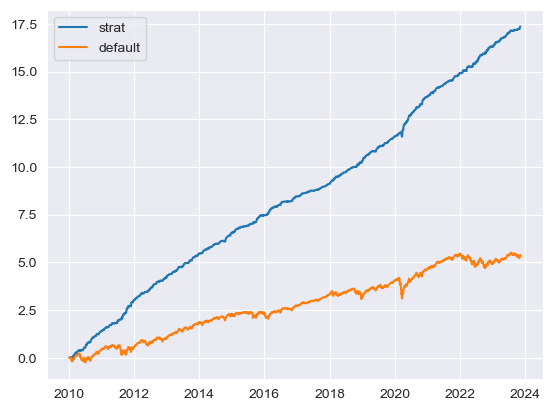

In [17]:
plt.plot(data['cumulative_return'],label = 'strat')
plt.plot(data['default_cumulative_return'],label = 'default')
plt.legend()
plt.show()

In [22]:
def calculate_first_entries(positions):
    """
    Calculate the number of trading opportunities based on the first occurrence of 1 in the positions series.

    Parameters:
    - positions: pandas Series with binary values where 1 indicates an entry point for a trade

    Returns:
    - first_entries: The number of first entry points for trades
    """
    # Shift the series by 1 to compare with the previous value, fill the first NA with 0
    shifted_positions = positions.shift(1).fillna(0)
    # Identify the transitions from 0 to 1 which are our first entries
    first_entries = ((positions == 1) & (shifted_positions == 0)).sum()
    return first_entries

# Example usage:
# Assuming data is your dataframe and 'positions' is a column in your dataframe
num_trading_opportunities = calculate_first_entries(data['positions'])
print(f"Number of trading opportunities: {num_trading_opportunities}")

# Calculate the Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio for a set of returns.

    Parameters:
    - returns: Array of returns (e.g., daily returns)
    - risk_free_rate: Risk-free rate of return, defaults to 0

    Returns:
    - sharpe_ratio: The Sharpe Ratio
    """
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    return sharpe_ratio

sharpe_ratio = calculate_sharpe_ratio(data['strategy_return'])
print(f"Sharpe Ratio: {sharpe_ratio}")

def calculate_win_loss_ratio(data):
    """
    Calculate the win/loss ratio for trades based on entry and exit points.

    Parameters:
    - data: DataFrame with 'positions' and 'Close' columns, where 'positions' indicates trade entries with 1

    Returns:
    - win_loss_ratio: The win/loss ratio
    """
    # Initialize the list to store returns
    trade_returns = []

    # Track if currently in trade
    in_trade = False
    entry_price = None

    # Iterate through the dataframe
    for index, row in data.iterrows():
        # Check for trade entry
        if row['positions'] == 1 and not in_trade:
            in_trade = True
            entry_price = row['Close']

        # Check for trade exit
        elif row['positions'] == 0 and in_trade:
            in_trade = False
            exit_price = row['Close']
            trade_returns.append((exit_price - entry_price) / entry_price)

    # Separate wins and losses
    wins = [ret for ret in trade_returns if ret > 0]
    losses = [ret for ret in trade_returns if ret <= 0]

    # Calculate win/loss ratio
    win_loss_ratio = len(wins) / len(losses) if losses else np.inf
    return win_loss_ratio

# Example usage:
win_loss_ratio = calculate_win_loss_ratio(data)
print(f"Win/Loss Ratio: {win_loss_ratio}")


Number of trading opportunities: 433
Sharpe Ratio: 0.4257894732864378
Win/Loss Ratio: 0.7745901639344263


In [24]:
data['return']

Date
2010-01-04 00:00:00-05:00         NaN
2010-01-05 00:00:00-05:00         NaN
2010-01-06 00:00:00-05:00         NaN
2010-01-07 00:00:00-05:00    0.007589
2010-01-08 00:00:00-05:00    0.008273
                               ...   
2023-11-02 00:00:00-04:00    0.036502
2023-11-03 00:00:00-04:00    0.039431
2023-11-06 00:00:00-05:00    0.030829
2023-11-07 00:00:00-05:00    0.014323
2023-11-08 00:00:00-05:00    0.005889
Name: return, Length: 3487, dtype: float64

In [26]:
import statsmodels.api as sm

# Create a new DataFrame with the columns for regression
regression_df = pd.DataFrame({
    'strategy_returns': data['strategy_return'],
    'market_returns': data['return']
})

# Drop rows with NaN values in either column
regression_df.dropna(subset=['strategy_returns', 'market_returns'], inplace=True)

# Check for infinite values and replace them with NaN, then drop those rows
regression_df.replace([np.inf, -np.inf], np.nan, inplace=True)
regression_df.dropna(subset=['strategy_returns', 'market_returns'], inplace=True)

# Add a constant to the market returns for the regression intercept
X = sm.add_constant(regression_df['market_returns'])  # Independent variable, with constant added
y = regression_df['strategy_returns']  # Dependent variable

# Create the OLS model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print out the statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:       strategy_returns   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     4001.
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:37:58   Log-Likelihood:                 11885.
No. Observations:                3484   AIC:                        -2.377e+04
Df Residuals:                    3482   BIC:                        -2.375e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0042      0.000     31.

Coefficient for const (Alpha): The intercept term (often interpreted as the expected return of the strategy not explained by market movements) is 0.0042, or 0.42% per the period analyzed (assuming it's daily, this would be per day). The p-value is less than 0.05, which suggests that the alpha is statistically significantly different from 0 at conventional levels, indicating that the strategy, on average, yields a positive return that is not explained by the market's performance.

Coefficient for market_returns (Beta): The coefficient of 0.4753 suggests that for every 1% increase in market returns, the strategy returns 0.4753%. This beta is significantly different from 0, as indicated by its p-value.

p-values: Both the alpha and beta have p-values less than 0.05, which means they are statistically significant at the 5% level.

Confidence intervals: The 95% confidence intervals for both alpha and beta do not contain 0, further confirming their significance.

Durbin-Watson Statistic: The Durbin-Watson statistic is close to 1.5, which suggests there is no strong evidence of autocorrelation in the residuals of your model.

Omnibus and Jarque-Bera Tests: These tests indicate whether the residuals are normally distributed. A Prob(Omnibus) or Prob(JB) close to 0 implies the residuals are not normally distributed, which is the case here.

Kurtosis: A kurtosis greater than 3 (which is the kurtosis of a normal distribution) suggests that the tails are fatter than a normal distribution. In this case, the kurtosis is significantly higher than 3, suggesting the presence of outliers or large jumps in your return distribution.

Skew: Skewness measures the asymmetry of the probability distribution of your returns. A skewness of 1.005 indicates a moderate right skew, meaning there are more unusually large returns than large losses in your strategy's return distribution.

In theory, a strategy with a significant alpha (indicating performance above the benchmark after accounting for market exposure) and a positive beta (indicating a positive correlation with the market) might be considered good. However, the real-world effectiveness of the strategy also depends on factors not captured in this model, such as:

Transaction Costs: These can significantly eat into returns and are not accounted for in the above analysis.
Market Impact: Especially for larger strategies, the act of trading can itself affect the market price.
Risk Adjusted Returns: You may want to look at measures like the Sharpe ratio, which adjusts for the volatility of the strategy's returns.
Out-of-Sample Performance: It's crucial to test how the strategy performs on data that was not used in the model fitting process.
Stability Over Time: Market conditions change, and strategies that work well in one period may not work in another.

If your goal is to establish that your trading strategy is statistically significant, regressing against SPY returns can still be useful, but your focus would be slightly different:

Alpha Significance: In this regression, you're particularly interested in the alpha (the intercept). If the alpha is statistically significant (with a low p-value), it indicates that your strategy's performance is not simply a result of market movements. In other words, your strategy is earning a return that is not explained by the overall market returns, which suggests that the strategy may have merit on its own.

Strategy Return Independence: If your strategy has a low R-squared in this regression, it means that the strategy's returns are not well explained by the market's returns, suggesting a degree of independence from overall market performance. This can be desirable if you're looking for diversification or if you're trying to prove that your strategy can generate alpha irrespective of market conditions.

T-Statistic for Alpha: You would look at the t-statistic for the alpha term to judge whether the performance above or below the market is statistically significant. A high absolute value of the t-statistic (typically greater than 2 in absolute value for a 95% confidence level) indicates that the alpha is significantly different from zero.

Non-Market Factors: Additionally, you might want to examine other factors that could affect your strategy's performance, such as different market sectors, interest rates, economic indicators, or specific events. In this case, a multi-factor regression model might be more appropriate.

In [71]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Define the ticker symbol and period
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)

# Fetching daily data from the start date up to the current date
data = tickerData.history(period='1d', start='2010-1-1')
data = data.reset_index()

# Calculate the Average True Range (ATR)
atr_period = 14  # Typical period used for ATR
data['High_Low'] = data['High'] - data['Low']
data['High_Close'] = (data['High'] - data['Close'].shift()).abs()
data['Low_Close'] = (data['Low'] - data['Close'].shift()).abs()
data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Define look back and holding periods
look_back = 3
holding_period = 3

# Calculate returns and signals
data['return'] = data['Close'] / data['Close'].shift(look_back) - 1
data['signal'] = np.where(data['return'].shift(-1) > 0, 1, 0)  # Signal one day after positive return

# Initialize a flag to track whether a position is open
position_open = False
entry_date = None
entry_price = None
entry_reason = None

# Create columns to store position information
data['positions'] = 0
data['strategy_return'] = 0.0

# ...

# Loop through the DataFrame to simulate the strategy
for j in range(0, len(data), holding_period):
    if data.loc[j, 'signal'] > 0:  # If there is a signal to enter a position
        entry_price = data.loc[j + 1, 'Open']  # Enter one day after the signal
        data.loc[j + 1, 'positions'] = 1  # Enter the position

        # Calculate stop loss and take profit prices, considering ATR if available
        if not np.isnan(data.loc[j + 1, 'ATR']):
            stop_loss_price = entry_price - data.loc[j + 1, 'ATR']
            take_profit_price = entry_price + data.loc[j + 1, 'ATR']
        else:
            # Set predefined fixed values for stop loss and take profit
            stop_loss_price = entry_price - 2.0  # Adjust with your desired value
            take_profit_price = entry_price + 2.0  # Adjust with your desired value

        # Check for stop loss and take profit conditions for the next `holding_period` days
        for y in range(1, holding_period + 1):
            if j + y >= len(data):
                break  # Ensure we don't go beyond the data length
            day_high = data.loc[j + y, 'High']
            day_low = data.loc[j + y, 'Low']

            # Check take profit and stop loss conditions
            if day_high >= take_profit_price:
                data.loc[j + y, 'positions'] = 0  # Exit the position at take profit
                break  # No need to check further
            elif day_low <= stop_loss_price:
                data.loc[j + y, 'positions'] = 0  # Exit the position at stop loss
                break  # No need to check further

# ...


# Calculate cumulative returns
data['cumulative_return'] = (1 + data['strategy_return']).cumprod()

# Optional: Calculate and print the strategy's return
data['strategy_return'] = data['positions']* data['return']
cumulative_strategy_return = data['strategy_return'].cumsum()
data['cumulative_return'] = cumulative_strategy_return
print("Cumulative Strategy Return: ", cumulative_strategy_return.iloc[-1])

data['default_cumulative_return'] = data['return'].cumsum()


Cumulative Strategy Return:  7.153422829116556


In [73]:
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,High_Low,High_Close,Low_Close,TR,ATR,return,signal,positions,strategy_return,cumulative_return,default_cumulative_return
0,2010-01-04,86.742152,87.529522,86.078289,87.483208,118944600,0.0,0,1.451233,NaN,NaN,1.451233,NaN,NaN,0,0,NaN,NaN,NaN
1,2010-01-05,87.429156,87.753366,87.112661,87.714767,111579900,0.0,0,0.640706,0.270159,0.370547,0.640706,NaN,NaN,0,0,NaN,NaN,NaN
2,2010-01-06,87.629858,87.992668,87.560387,87.776527,116074400,0.0,0,0.432281,0.277900,0.154380,0.432281,NaN,NaN,1,0,NaN,NaN,NaN
3,2010-01-07,87.614421,88.255127,87.367402,88.147057,131091100,0.0,0,0.887724,0.478599,0.409125,0.887724,NaN,0.007588,1,0,0.000000,0.000000,0.007588
4,2010-01-08,87.915484,88.478998,87.737943,88.440399,126402800,0.0,0,0.741055,0.331942,0.409114,0.741055,NaN,0.008273,1,1,0.008273,0.008273,0.015861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,2023-11-06,435.470001,436.149994,433.679993,435.690002,67831700,0.0,0,2.470001,1.459991,1.010010,2.470001,5.737148,0.030829,1,1,0.030829,7.153423,5.368565
3485,2023-11-07,435.690002,437.589996,434.510010,436.929993,64256100,0.0,0,3.079987,1.899994,1.179993,3.079987,5.462147,0.014323,1,0,0.000000,7.153423,5.382888
3486,2023-11-08,437.549988,438.089996,434.869995,437.250000,61746000,0.0,0,3.220001,1.160004,2.059998,3.220001,5.185719,0.005889,0,0,0.000000,7.153423,5.388778
3487,2023-11-09,438.429993,438.470001,433.399994,433.839996,83174400,0.0,0,5.070007,1.220001,3.850006,5.070007,5.157861,-0.004246,1,0,-0.000000,7.153423,5.384531


In [72]:
data['Date'] = data['Date'].dt.tz_localize(None)

# Write the DataFrame to an Excel file
data.to_excel("output_test.xlsx", index=False)

data.to_excel('output_test.xlsx')

In [84]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the ticker symbol and period
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)

# Fetching daily data from the start date up to the current date
data = tickerData.history(period='1d', start='2010-1-1')
data = data.reset_index()

# Calculate the Average True Range (ATR)
atr_period = 14
data['High_Low'] = data['High'] - data['Low']
data['High_Close'] = (data['High'] - data['Close'].shift()).abs()
data['Low_Close'] = (data['Low'] - data['Close'].shift()).abs()
data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Define look back and holding periods
look_back = 3
holding_period = 3

# Calculate returns and signals
data['return'] = data['Close'] / data['Close'].shift(look_back) - 1
data['signal'] = np.where(data['return'].shift(-1) > 0, 1, 0)

# Initialize a flag to track whether a position is open and its duration
position_open = False
position_duration = 0

# Create columns to store position information and tracking columns
data['positions'] = 0
data['take_profit_hit'] = 0
data['stop_loss_hit'] = 0
data['take_profit_price'] = np.nan  # New column for take profit price
data['stop_loss_price'] = np.nan  # New column for stop loss price
data['strategy_return'] = 0.0

# Loop through the DataFrame to simulate the strategy
for j in range(len(data)):
    # Check if there is a signal to enter a position and no position is open
    if data.loc[j, 'signal'] > 0 and not position_open:
        position_open = True
        position_duration = 0
        entry_price = data.loc[j + 1, 'Open'] if j + 1 < len(data) else None

        # Set stop loss and take profit prices based on ATR
        if entry_price and not np.isnan(data.loc[j + 1, 'ATR']):
            stop_loss_price = entry_price - data.loc[j + 1, 'ATR']
            take_profit_price = entry_price + data.loc[j + 1, 'ATR']
        else:
            # Set predefined fixed values if ATR is not available
            stop_loss_price = entry_price - 2.0 if entry_price else None
            take_profit_price = entry_price + 2.0 if entry_price else None

        # Mark position entry for the next day and set prices
        if entry_price:
            data.loc[j + 1, 'positions'] = 1
            data.loc[j + 1, 'take_profit_price'] = take_profit_price
            data.loc[j + 1, 'stop_loss_price'] = stop_loss_price

    # Process the position if it's open
    if position_open:
        position_duration += 1
        day_high = data.loc[j, 'High']
        day_low = data.loc[j, 'Low']

        # Check for take profit or stop loss conditions
        if day_high >= take_profit_price:
            data.loc[j, 'positions'] = 0
            data.loc[j, 'take_profit_hit'] = 1
            position_open = False
        elif day_low <= stop_loss_price:
            data.loc[j, 'positions'] = 0
            data.loc[j, 'stop_loss_hit'] = 1
            position_open = False
        elif position_duration >= holding_period:
            data.loc[j, 'positions'] = 0  # Close the position after holding period
            position_open = False


# Calculate cumulative returns
data['strategy_return'] = data['positions'].shift(1) * data['return']
data['cumulative_strategy_return'] = data['strategy_return'].cumsum()
print("Cumulative Strategy Return: ", data['cumulative_strategy_return'].iloc[-1])

# Optional: Compare with default market cumulative return
data['default_cumulative_return'] = data['return'].cumsum()

# [Further analysis and plotting can be added here]


Cumulative Strategy Return:  7.345423151488018


In [85]:
data['Date'] = data['Date'].dt.tz_localize(None)


# Write the DataFrame to an Excel file
data.to_excel("output_test.xlsx", index=False)

data.to_excel('output_test.xlsx')

In [100]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the ticker symbol and period
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)

# Fetching daily data from the start date up to the current date
data = tickerData.history(period='1d', start='2010-1-1')
data = data.reset_index()

# Calculate the Average True Range (ATR)
atr_period = 14
data['High_Low'] = data['High'] - data['Low']
data['High_Close'] = (data['High'] - data['Close'].shift()).abs()
data['Low_Close'] = (data['Low'] - data['Close'].shift()).abs()
data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Define look back and holding periods
look_back = 3
holding_period = 3

# Calculate returns and signals
data['return'] = data['Close'] / data['Close'].shift(look_back) - 1
data['signal'] = np.where(data['return'].shift(-1) > 0, 1, 0)

# Initialize a flag to track whether a position is open and its duration
position_open = False
position_duration = 0

# Create columns to store position information and tracking columns
data['positions'] = 0
data['take_profit_hit'] = 0
data['stop_loss_hit'] = 0
data['take_profit_price'] = np.nan  # New column for take profit price
data['stop_loss_price'] = np.nan  # New column for stop loss price
data['strategy_return'] = 0.0

# Loop through the DataFrame to simulate the strategy
for j in range(len(data)):
    # Check if there is a signal to enter a position and no position is open
    if data.loc[j, 'signal'] > 0 and not position_open:
        position_open = True
        position_duration = 0  # Reset duration on the day of signal
        entry_price = data.loc[j + 1, 'Open'] if j + 1 < len(data) else None

        # Set stop loss and take profit prices based on ATR
        if entry_price and not np.isnan(data.loc[j + 1, 'ATR']):
            stop_loss_price = entry_price - data.loc[j + 1, 'ATR']
            take_profit_price = entry_price + data.loc[j + 1, 'ATR']
        else:
            # Set predefined fixed values if ATR is not available
            stop_loss_price = entry_price - 2.0 if entry_price else None
            take_profit_price = entry_price + 2.0 if entry_price else None

        # Mark position entry for the next day and set prices
        if entry_price:
            data.loc[j + 1, 'positions'] = 1
            data.loc[j + 1, 'take_profit_price'] = take_profit_price
            data.loc[j + 1, 'stop_loss_price'] = stop_loss_price

        #skip to the next iteration to avoid entering and checking on the same day
        continue

    # Process the position if it's open
    if position_open:
        # Increment duration only if position is open
        position_duration += 1

        # Check for take profit or stop loss conditions
        if data.loc[j, 'High'] >= take_profit_price:
            data.loc[j, 'positions'] = 0
            data.loc[j, 'take_profit_hit'] = 1
            position_open = False
        elif data.loc[j, 'Low'] <= stop_loss_price:
            data.loc[j, 'positions'] = 0
            data.loc[j, 'stop_loss_hit'] = 1
            position_open = False
        elif position_duration >= holding_period:
            data.loc[j, 'positions'] = 0
            position_open = False


# Calculate cumulative returns
data['strategy_return'] = data['positions'].shift(1) * data['return']
data['cumulative_strategy_return'] = data['strategy_return'].cumsum()
print("Cumulative Strategy Return: ", data['cumulative_strategy_return'].iloc[-1])

# Optional: Compare with default market cumulative return
data['default_cumulative_return'] = data['return'].cumsum()

# [Further analysis and plotting can be added here]


data['Date'] = data['Date'].dt.tz_localize(None)


# Write the DataFrame to an Excel file
data.to_excel("output_test.xlsx", index=False)

data.to_excel('output_test.xlsx')

Cumulative Strategy Return:  5.514185705606177


In [106]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the ticker symbol and period
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)

# Fetching daily data from the start date up to the current date
data = tickerData.history(period='1d', start='2010-1-1')
data = data.reset_index()

# Calculate the Average True Range (ATR)
atr_period = 14
data['High_Low'] = data['High'] - data['Low']
data['High_Close'] = (data['High'] - data['Close'].shift()).abs()
data['Low_Close'] = (data['Low'] - data['Close'].shift()).abs()
data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Define look back and holding periods
look_back = 3
holding_period = 3

# Calculate returns and signals
data['return'] = data['Close'] / data['Close'].shift(look_back) - 1
data['signal'] = np.where(data['return'].shift(-1) > 0, 1, 0)

# Initialize variables to track whether a position is open, its duration, entry price, and stop loss/take profit prices
position_open = False
position_duration = 0
entry_price = None
take_profit_price = None
stop_loss_price = None

# Create columns to store position information and tracking columns
data['positions'] = 0
data['take_profit_hit'] = 0
data['stop_loss_hit'] = 0
data['take_profit_price'] = np.nan
data['stop_loss_price'] = np.nan
data['strategy_return'] = 0.0

# Loop through the DataFrame to simulate the strategy
for j in range(len(data)):
    # Check if there is a signal to enter a position and no position is open
    if data.loc[j, 'signal'] > 0 and not position_open:
        position_open = True
        position_duration = holding_period
        entry_price = data.loc[j + 1, 'Open'] if j + 1 < len(data) else None

        # Set stop loss and take profit prices based on ATR
        if entry_price:
            stop_loss_price = entry_price - data.loc[j, 'ATR']
            take_profit_price = entry_price + data.loc[j, 'ATR']

    # Process the position if it's open
    if position_open:
        # Update position details for the day
        data.loc[j, 'positions'] = 1
        data.loc[j, 'take_profit_price'] = take_profit_price
        data.loc[j, 'stop_loss_price'] = stop_loss_price

        # Check for take profit or stop loss conditions
        if data.loc[j, 'High'] >= take_profit_price:
            data.loc[j, 'take_profit_hit'] = 1
            position_open = False
        elif data.loc[j, 'Low'] <= stop_loss_price:
            data.loc[j, 'stop_loss_hit'] = 1
            position_open = False

        # Decrement the position duration
        position_duration -= 1
        if position_duration <= 0:
            position_open = False

# Calculate cumulative returns
data['strategy_return'] = data['positions'].shift(1) * data['return']
data['cumulative_strategy_return'] = data['strategy_return'].cumsum()
print("Cumulative Strategy Return: ", data['cumulative_strategy_return'].iloc[-1])

# Optional: Compare with default market cumulative return
data['default_cumulative_return'] = data['return'].cumsum()

# Remove timezone information for Excel compatibility
data['Date'] = data['Date'].dt.tz_localize(None)

# Write the DataFrame to an Excel file
data.to_excel("output_test.xlsx", index=False)



Cumulative Strategy Return:  21.17903933196973


In [107]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the ticker symbol and period
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)

# Fetching daily data from the start date up to the current date
data = tickerData.history(period='1d', start='2010-1-1')
data = data.reset_index()

# Calculate the Average True Range (ATR)
atr_period = 14
data['High_Low'] = data['High'] - data['Low']
data['High_Close'] = (data['High'] - data['Close'].shift()).abs()
data['Low_Close'] = (data['Low'] - data['Close'].shift()).abs()
data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Define look back and holding periods
look_back = 3
holding_period = 3

# Calculate returns and signals
data['return'] = data['Close'] / data['Close'].shift(look_back) - 1
data['signal'] = np.where(data['return'].shift(-1) > 0, 1, 0)

# Create columns to store position information and tracking columns
data['positions'] = 0
data['take_profit_hit'] = 0
data['stop_loss_hit'] = 0
data['take_profit_price'] = np.nan
data['stop_loss_price'] = np.nan
data['strategy_return'] = 0.0
data['holding_days_left'] = np.nan  # Tracks the remaining holding days for an open position

# Loop through the DataFrame to simulate the strategy
for j in range(len(data)):
    if j + 1 < len(data) and data.loc[j, 'signal'] > 0:
        # Set the holding days for the next day
        data.loc[j + 1, 'holding_days_left'] = holding_period

    if not np.isnan(data.loc[j, 'holding_days_left']):
        if data.loc[j, 'holding_days_left'] == holding_period:
            # Record the entry price
            entry_price = data.loc[j, 'Open']
            # Set stop loss and take profit prices based on ATR
            data.loc[j, 'take_profit_price'] = entry_price + data.loc[j, 'ATR']
            data.loc[j, 'stop_loss_price'] = entry_price - data.loc[j, 'ATR']
            # Mark the position entry
            data.loc[j, 'positions'] = 1

        # Check for take profit or stop loss conditions
        if data.loc[j, 'High'] >= data.loc[j, 'take_profit_price']:
            data.loc[j, 'take_profit_hit'] = 1
            data.loc[j, 'positions'] = 0
            data.loc[j, 'holding_days_left'] = np.nan
        elif data.loc[j, 'Low'] <= data.loc[j, 'stop_loss_price']:
            data.loc[j, 'stop_loss_hit'] = 1
            data.loc[j, 'positions'] = 0
            data.loc[j, 'holding_days_left'] = np.nan
        else:
            data.loc[j, 'holding_days_left'] -= 1
            if data.loc[j, 'holding_days_left'] == 0:
                data.loc[j, 'positions'] = 0
                data.loc[j, 'holding_days_left'] = np.nan

# Calculate cumulative returns
data['strategy_return'] = data['positions'].shift(1) * data['return']
data['cumulative_strategy_return'] = data['strategy_return'].cumsum()
print("Cumulative Strategy Return: ", data['cumulative_strategy_return'].iloc[-1])

# Optional: Compare with default market cumulative return
data['default_cumulative_return'] = data['return'].cumsum()

# Remove timezone information for Excel compatibility
data['Date'] = data['Date'].dt.tz_localize(None)

# Write the DataFrame to an Excel file
data.to_excel("output_test.xlsx", index=False)


Cumulative Strategy Return:  15.27329782590894


In [110]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the ticker symbol and period
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)

# Fetching daily data from the start date up to the current date
data = tickerData.history(period='1d', start='2010-1-1')
data = data.reset_index()

# Calculate the Average True Range (ATR)
atr_period = 14
data['High_Low'] = data['High'] - data['Low']
data['High_Close'] = (data['High'] - data['Close'].shift()).abs()
data['Low_Close'] = (data['Low'] - data['Close'].shift()).abs()
data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Define look back and holding periods
look_back = 3
holding_period = 3

# Calculate returns and signals
data['return'] = data['Close'] / data['Close'].shift(look_back) - 1
data['signal'] = np.where(data['return'].shift(-1) > 0, 1, 0)

# Create columns to store position information and tracking columns
data['positions'] = 0
data['take_profit_hit'] = 0
data['stop_loss_hit'] = 0
data['take_profit_price'] = np.nan
data['stop_loss_price'] = np.nan
data['strategy_return'] = 0.0
data['holding_days_left'] = np.nan  # Tracks the remaining holding days for an open position

# Loop through the DataFrame to simulate the strategy
for j in range(len(data)):
    if j + 1 < len(data) and data.loc[j, 'signal'] > 0:
        # Set the holding days for the next day
        data.loc[j + 1, 'holding_days_left'] = holding_period - 1  # Holding starts next day

    if not np.isnan(data.loc[j, 'holding_days_left']):
        if data.loc[j, 'holding_days_left'] == holding_period - 1:
            # Record the entry price
            entry_price = data.loc[j, 'Open']
            # Set stop loss and take profit prices based on ATR
            data.loc[j, 'take_profit_price'] = entry_price + data.loc[j, 'ATR']
            data.loc[j, 'stop_loss_price'] = entry_price - data.loc[j, 'ATR']
            # Mark the position entry
            data.loc[j, 'positions'] = 1

        # Check for take profit or stop loss conditions
        if data.loc[j, 'High'] >= data.loc[j, 'take_profit_price']:
            data.loc[j, 'take_profit_hit'] = 1
            data.loc[j, 'positions'] = 0
            data.loc[j, 'holding_days_left'] = np.nan
        elif data.loc[j, 'Low'] <= data.loc[j, 'stop_loss_price']:
            data.loc[j, 'stop_loss_hit'] = 1
            data.loc[j, 'positions'] = 0
            data.loc[j, 'holding_days_left'] = np.nan
        else:
            data.loc[j, 'holding_days_left'] -= 1
            if data.loc[j, 'holding_days_left'] == 0:
                data.loc[j, 'positions'] = 0
                data.loc[j, 'holding_days_left'] = np.nan

# Calculate cumulative returns
data['strategy_return'] = data['positions'].shift(1) * data['return']
data['cumulative_strategy_return'] = data['strategy_return'].cumsum()
print("Cumulative Strategy Return: ", data['cumulative_strategy_return'].iloc[-1])

# Optional: Compare with default market cumulative return
data['default_cumulative_return'] = data['return'].cumsum()

# Remove timezone information for Excel compatibility
data['Date'] = data['Date'].dt.tz_localize(None)

# Write the DataFrame to an Excel file
data.to_excel("output_test.xlsx", index=False)

Cumulative Strategy Return:  15.27330287021707


In [117]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the ticker symbol and period
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)

# Fetching daily data from the start date up to the current date
data = tickerData.history(period='1d', start='2010-1-1')
data = data.reset_index()

# Calculate the Average True Range (ATR)
atr_period = 14
data['High_Low'] = data['High'] - data['Low']
data['High_Close'] = (data['High'] - data['Close'].shift()).abs()
data['Low_Close'] = (data['Low'] - data['Close'].shift()).abs()
data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Define look back and holding periods
look_back = 3
holding_period = 3

# Calculate returns and signals
data['return'] = data['Close'] / data['Close'].shift(look_back) - 1
data['signal'] = np.where(data['return'].shift(-1) > 0, 1, 0)

# Initialize a flag to track whether a position is open and its duration
position_open = False
position_duration = 0

# Initialize columns for trading strategy simulation
data['positions'] = 0
data['take_profit_hit'] = 0
data['stop_loss_hit'] = 0
data['take_profit_price'] = np.nan
data['stop_loss_price'] = np.nan
data['strategy_return'] = 0.0

# Loop through the DataFrame to simulate the strategy
for j in range(len(data) - 1):
    # Check if there is a signal to enter a position and no position is open
    if data.loc[j, 'signal'] > 0 and not position_open:
        position_open = True
        position_duration = holding_period  # Set the holding period

        # Calculate entry price for the next day
        entry_price = data.loc[j + 1, 'Open'] if j + 1 < len(data) else None
        # Calculate stop loss and take profit prices
        stop_loss_price = entry_price - data.loc[j, 'ATR'] if entry_price else None
        take_profit_price = entry_price + data.loc[j, 'ATR'] if entry_price else None

        # Update the DataFrame with the trading details for the next day
        if entry_price:
            data.loc[j + 1, 'positions'] = 1
            data.loc[j + 1, 'take_profit_price'] = take_profit_price
            data.loc[j + 1, 'stop_loss_price'] = stop_loss_price
        continue  # Skip to the next day

    # If a position is open, manage it
    if position_open:
        # Decrement the holding period
        position_duration -= 1

        # Check for take profit or stop loss conditions
        if data.loc[j, 'High'] >= take_profit_price:
            data.loc[j, 'take_profit_hit'] = 1
            data.loc[j, 'positions'] = 0
            position_open = False
        elif data.loc[j, 'Low'] <= stop_loss_price:
            data.loc[j, 'stop_loss_hit'] = 1
            data.loc[j, 'positions'] = 0
            position_open = False
        elif position_duration == 0:
            # Close the position if the holding period is over
            data.loc[j, 'positions'] = 0
            position_open = False

# Calculate cumulative returns
data['strategy_return'] = data['positions'].shift(1) * data['return']
data['cumulative_strategy_return'] = data['strategy_return'].cumsum()

# Optional: Compare with default market cumulative return
data['default_cumulative_return'] = data['return'].cumsum()

# Remove timezone information for Excel compatibility
data['Date'] = data['Date'].dt.tz_localize(None)

# Write the DataFrame to an Excel file
data.to_excel("output_test.xlsx", index=False)


Failed to get ticker 'SPY' reason: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v8/finance/chart/SPY?range=1d&interval=1d (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000212777374F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
- SPY: No data found for this date range, symbol may be delisted


AttributeError: Can only use .dt accessor with datetimelike values

In [114]:
print("Cumulative Strategy Return: ", data['cumulative_strategy_return'].iloc[-1])

Cumulative Strategy Return:  5.522003970472706


In [124]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the ticker symbol and period
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)

# Fetching daily data from the start date up to the current date
data = tickerData.history(period='1d', start='2010-1-1')
data = data.reset_index()

# Calculate the Average True Range (ATR)
atr_period = 14
data['High_Low'] = data['High'] - data['Low']
data['High_Close'] = (data['High'] - data['Close'].shift()).abs()
data['Low_Close'] = (data['Low'] - data['Close'].shift()).abs()
data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Define look back and holding periods
look_back = 3
holding_period = 3

# Calculate returns and signals
data['return'] = data['Close'] / data['Close'].shift(look_back) - 1
data['signal'] = np.where(data['return'].shift(-1) > 0, 1, 0)

# Initialize variables to track whether a position is open, its duration, entry price, and stop loss/take profit prices
position_open = False
position_duration = 0
entry_price = None
take_profit_price = None
stop_loss_price = None

# Create columns to store position information and tracking columns
data['positions'] = 0
data['take_profit_hit'] = 0
data['stop_loss_hit'] = 0
data['take_profit_price'] = np.nan
data['stop_loss_price'] = np.nan
data['strategy_return'] = 0.0

# Loop through the DataFrame to simulate the strategy
for j in range(len(data)):
    # Check if there is a signal to enter a position and no position is open
    if data.loc[j, 'signal'] > 0 and not position_open:
        position_open = True
        position_duration = holding_period
        entry_price = data.loc[j + 1, 'Open'] if j + 1 < len(data) else None

        # Set stop loss and take profit prices based on ATR
        if entry_price:
            stop_loss_price = entry_price - data.loc[j, 'ATR']
            take_profit_price = entry_price + data.loc[j, 'ATR']

    # Process the position if it's open
    if position_open:
        # Update position details for the day
        data.loc[j+1, 'positions'] = 1
        data.loc[j+1, 'take_profit_price'] = take_profit_price
        data.loc[j+1, 'stop_loss_price'] = stop_loss_price

        # Check for take profit or stop loss conditions
        if data.loc[j, 'High'] >= take_profit_price:
            data.loc[j, 'take_profit_hit'] = 1
            position_open = False
        elif data.loc[j, 'Low'] <= stop_loss_price:
            data.loc[j, 'stop_loss_hit'] = 1
            position_open = False

        # Decrement the position duration
        position_duration -= 1
        if position_duration <= 0:
            position_open = False

# Calculate cumulative returns
data['strategy_return'] = data['positions'].shift(1) * data['return']
data['cumulative_strategy_return'] = data['strategy_return'].cumsum()
print("Cumulative Strategy Return: ", data['cumulative_strategy_return'].iloc[-1])

# Optional: Compare with default market cumulative return
data['default_cumulative_return'] = data['return'].cumsum()

# Remove timezone information for Excel compatibility
data['Date'] = data['Date'].dt.tz_localize(None)

# Write the DataFrame to an Excel file
data.to_excel("output_test.xlsx", index=False)



Cumulative Strategy Return:  nan


[*********************100%***********************]  1 of 1 completed


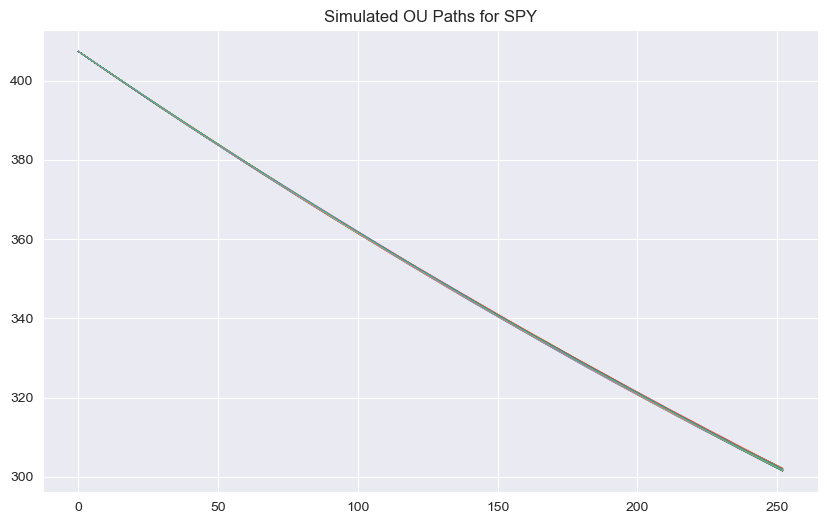

In [129]:
import yfinance as yf


# Fetch SPY data
data = yf.download('SPY', start='2022-12-01', end='2023-11-01')
prices = data['Close']

# Placeholder for parameter estimation (you'll need to replace this with actual estimation)
theta, kappa, sigma = 0.1, 0.3, 0.2

# OU process simulation function
def simulate_OU(S0, theta, kappa, sigma, T, dt, N):
    num_steps = int(T / dt)
    paths = np.zeros((num_steps + 1, N))
    paths[0] = S0

    for t in range(1, num_steps + 1):
        dt = t * dt - (t - 1) * dt
        dW = np.random.normal(scale=np.sqrt(dt), size=N)
        paths[t] = paths[t - 1] + kappa * (theta - paths[t - 1]) * dt + sigma * dW

    return paths

# Simulate paths
T = 1  # Total time (years)
dt = 1/252  # Time step (daily)
N = 100  # Number of paths
S0 = prices.iloc[0]  # Starting price (most recent price)
simulated_paths = simulate_OU(S0, theta, kappa, sigma, T, dt, N)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(simulated_paths[:, i], linewidth=0.5)
plt.title('Simulated OU Paths for SPY')
plt.show()



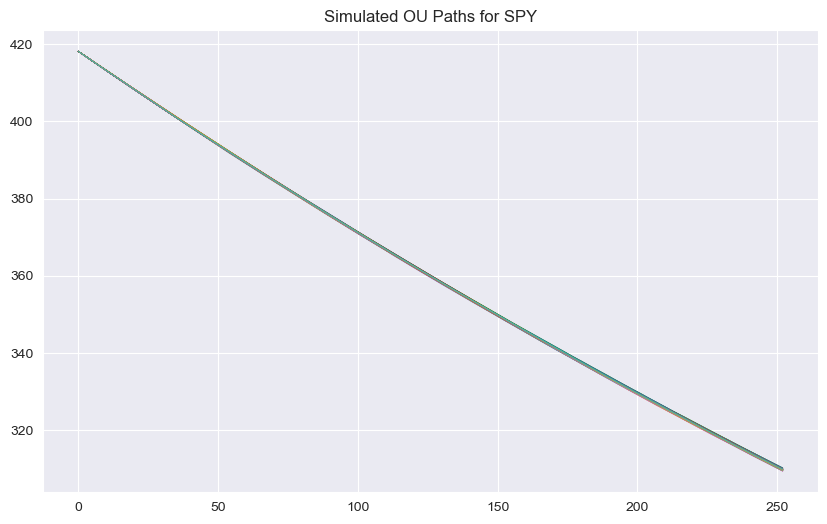

In [130]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_OU(S0, theta, kappa, sigma, T, dt, N):
    num_steps = int(T / dt)
    paths = np.zeros((num_steps + 1, N))
    paths[0] = S0

    for t in range(1, num_steps + 1):
        dt = t * dt - (t - 1) * dt
        dW = np.random.normal(scale=np.sqrt(dt), size=N)
        paths[t] = paths[t - 1] + kappa * (theta - paths[t - 1]) * dt + sigma * dW

    return paths

# Simulation parameters
T = 1  # Total time in years
dt = 1/252  # Time step (daily)
N = 100  # Number of paths
S0 = prices.iloc[-1]  # Starting price (most recent price)

simulated_paths = simulate_OU(S0, theta, kappa, sigma, T, dt, N)

# Plotting the simulated paths
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(simulated_paths[:, i], linewidth=0.5)
plt.title('Simulated OU Paths for SPY')
plt.show()


[*********************100%***********************]  1 of 1 completed


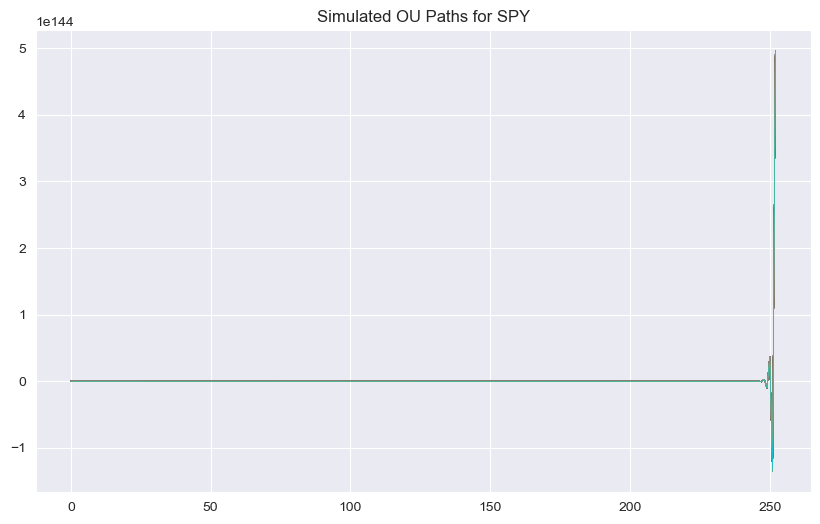

In [131]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Fetch SPY data
data = yf.download('SPY', start='2022-01-01', end='2023-01-01')
prices = data['Close']

# Calculate daily returns
returns = prices.pct_change().dropna()

# Estimate OU parameters
# Using least squares regression to estimate speed of reversion (kappa) and long-term mean (theta)
# Volatility (sigma) is the standard deviation of the residuals
X = returns[:-1]
y = returns[1:]
X = np.column_stack([np.ones(len(X)), X])
a, b = np.linalg.lstsq(X, y, rcond=None)[0]
kappa = -np.log(b) * 252  # Annualize kappa
theta = a / (1 - b)
sigma = np.std(y - (a + b * X[:,1]))

# OU process simulation function
def simulate_OU(S0, theta, kappa, sigma, T, dt, N):
    num_steps = int(T / dt)
    paths = np.zeros((num_steps + 1, N))
    paths[0] = S0

    for t in range(1, num_steps + 1):
        dt = t * dt - (t - 1) * dt
        dW = np.random.normal(scale=np.sqrt(dt), size=N)
        paths[t] = paths[t - 1] + kappa * (theta - paths[t - 1]) * dt + sigma * dW

    return paths

# Simulate paths
T = 1  # Total time (years)
dt = 1/252  # Time step (daily)
N = 100  # Number of paths
S0 = prices.iloc[-1]  # Starting price (most recent price)
simulated_paths = simulate_OU(S0, theta, kappa, sigma, T, dt, N)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(simulated_paths[:, i], linewidth=0.5)
plt.title('Simulated OU Paths for SPY')
plt.show()


In [135]:
dt

0.003968253968253968

[*********************100%***********************]  1 of 1 completed


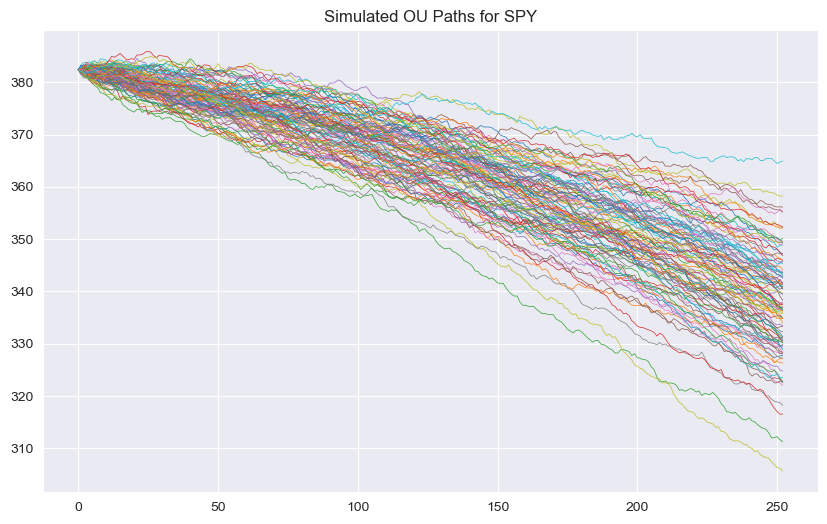

In [142]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fetch SPY data
data = yf.download('SPY', start='2022-01-01', end='2023-01-01')
prices = data['Close']

# Set target level as the mean of the time series
target_level = np.mean(prices)

# Prepare vectors X, Y, and Z
X = target_level - prices.shift(1)
Y = prices
Z = np.full_like(X, target_level)

# Align X and Y by removing NaN values from both
X = X[1:]  # Drop the first NaN value in X
Y = Y[1:]  # Drop the first value in Y to align with X

# Perform OLS Regression
kappa_hat = np.cov(Y, X)[0, 1] / np.cov(X, X)[0, 1]

# Calculate residuals
epsilon_hat = Y - Z[1:] - kappa_hat * X  # Adjust Z to align with X and Y

# Estimate sigma
sigma_hat = np.sqrt(np.var(epsilon_hat))

# OU process simulation function
def simulate_OU(S0, theta, kappa, sigma, T, dt, N):
    num_steps = int(T / dt)
    paths = np.zeros((num_steps + 1, N))
    paths[0] = S0

    for t in range(1, num_steps + 1):
        dt = t * dt - (t - 1) * dt
        dW = np.random.normal(scale=np.sqrt(dt), size=N)
        paths[t] = paths[t - 1] + kappa * (theta - paths[t - 1]) * dt + sigma * dW

    return paths

# Simulate paths
T = 1  # Total time (years)
dt = 1/252  # Time step (daily)
N = 100  # Number of paths
S0 = prices.iloc[-1]  # Starting price (most recent price)
simulated_paths = simulate_OU(S0, target_level, kappa_hat, sigma_hat, T, dt, N)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(simulated_paths[:, i], linewidth=0.5)
plt.title('Simulated OU Paths for SPY')
plt.show()
